# Data modification test

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets.sleep_physionet.age import fetch_data

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /home/anrath/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
Using matplotlib as 2D backend.


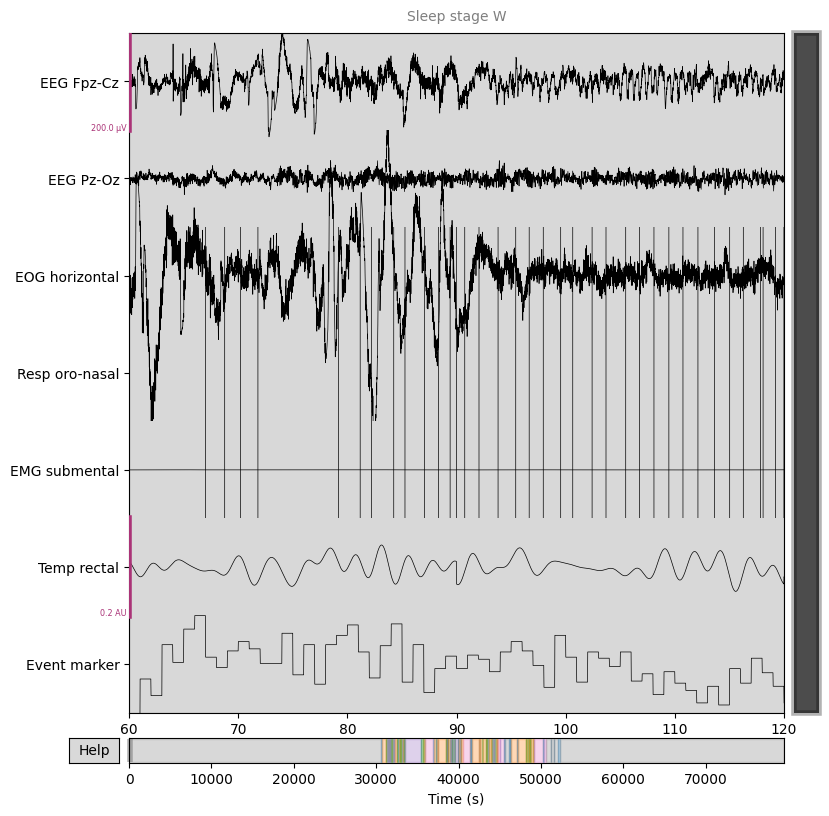

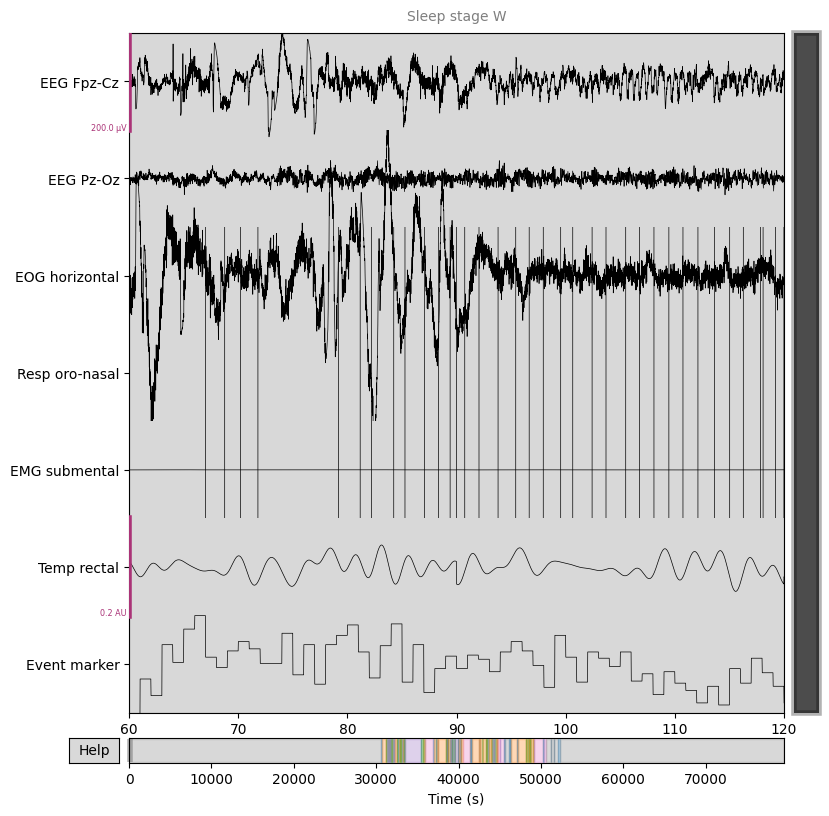

In [2]:
ALICE, BOB = 0, 1

[alice_files, bob_files] = fetch_data(subjects=[ALICE, BOB], recording=[1])

raw_train = mne.io.read_raw_edf(alice_files[0], stim_channel='Event marker',
                                misc=['Temp rectal'], preload=True)
annot_train = mne.read_annotations(alice_files[1])

raw_train.set_annotations(annot_train, emit_warning=False)

# plot some data
# scalings were chosen manually to allow for simultaneous visualization of
# different channel types in this specific dataset
raw_train.plot(start=60, duration=60,
               scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7,
                             misc=1e-1))

In [3]:
raw_train.get_data()

array([[ 5.01684982e-06, -2.57875458e-06,  1.35970696e-06, ...,
         5.29816850e-06, -4.64175824e-06,  6.61098901e-06],
       [-2.46739927e-06,  1.46739927e-06, -4.09890110e-06, ...,
        -3.04322344e-06, -3.71501832e-06,  1.75531136e-06],
       [ 1.65086691e-05,  1.60158730e-05,  9.60952381e-06, ...,
         6.97306471e-05,  8.05721612e-05,  1.02255189e-04],
       ...,
       [ 3.55200000e-06,  3.55356030e-06,  3.55509506e-06, ...,
         3.46427255e-06,  3.46481729e-06,  3.46539330e-06],
       [ 3.72064516e+01,  3.72061537e+01,  3.72058645e+01, ...,
         3.74298268e+01,  3.74295681e+01,  3.74293032e+01],
       [ 9.20000000e+02,  9.20000000e+02,  9.20000000e+02, ...,
         8.98000000e+02,  8.98000000e+02,  8.98000000e+02]])

In [4]:
raw_copy = raw_train.copy()
func_data = raw_copy.apply_function(np.abs)
func_data.get_data()

array([[5.01684982e-06, 2.57875458e-06, 1.35970696e-06, ...,
        5.29816850e-06, 4.64175824e-06, 6.61098901e-06],
       [2.46739927e-06, 1.46739927e-06, 4.09890110e-06, ...,
        3.04322344e-06, 3.71501832e-06, 1.75531136e-06],
       [1.65086691e-05, 1.60158730e-05, 9.60952381e-06, ...,
        6.97306471e-05, 8.05721612e-05, 1.02255189e-04],
       ...,
       [3.55200000e-06, 3.55356030e-06, 3.55509506e-06, ...,
        3.46427255e-06, 3.46481729e-06, 3.46539330e-06],
       [3.72064516e+01, 3.72061537e+01, 3.72058645e+01, ...,
        3.74298268e+01, 3.74295681e+01, 3.74293032e+01],
       [9.20000000e+02, 9.20000000e+02, 9.20000000e+02, ...,
        8.98000000e+02, 8.98000000e+02, 8.98000000e+02]])

In [5]:
def naive_logical_find_peaks(signal, min_distance=1, error=1e-6, minimum_peak_height=None):
    """
    Find peaks in a 1D array.
    
    Parameters
    ----------
    signal       : 1D array
    min_distance : minimum distance between peaks in signal
    error        : scales the adjustment of the signal to account for order of dataset

    Returns
    -------
    ind : 1D array
        indices of the peaks in `signal`
    
    """
    size = signal.size
    
    # Padding the begginning and end of the signal with a value
    # this makes sure that the first and last values of the signal are not peaks
    # and fixes out-of-bound errors
    pad = np.zeros(size+2*min_distance)
    pad[:min_distance] = signal[0]-error
    pad[-min_distance:] = signal[-1]-error
    pad[min_distance:min_distance+size] = signal

    # Any value could be a peak candidate
    peak_candidate_bools = np.zeros(size)
    peak_candidate_bools[:] = True
    
    for i in range(min_distance):
        start_before = min_distance - i - 1
        start_central = min_distance
        start_after = min_distance + i + 1

        x_before = pad[start_before : start_before + size]
        x_central = pad[start_central : start_central + size]
        x_after = pad[start_after : start_after + size]

        # A point is a peak candidate if it is larger than the points before and after it
        #   x_central > x_before and x_central > x_after
        temp_bools = np.logical_and(x_central > x_before, x_central > x_after)
        peak_candidate_bools = np.logical_and(peak_candidate_bools, temp_bools)

    # Find the indices of the peak candidates
    #   non-zero values of peak_candidate are the indices of the peaks
    ind = np.argwhere(peak_candidate_bools)
    ind = ind.reshape(ind.size)

    if minimum_peak_height is not None:
        ind = ind[signal[ind] > minimum_peak_height]

    return ind

def naive_mathematical_find_peaks(signal, threshold=0):
    """
    Performs peak detection on three steps: 
        1. root mean square
        2. peak to average ratios 
        3. first order logic.

    Parameters
    ----------
    signal : 1D array
    threshold : positive number, optional (default = 0)
        detect peaks that are greater than `threshold`
        in relation to their immediate neighbors.

    Returns
    -------
    peak_indexes : 1D array
        indices of the peaks in `signal`

    Notes
    -----
    Strong underlying assumption about the distribution of the signal being distributed properly.
    """

    if threshold == 0:
        threshold = (max(signal)-min(signal))/4

    root_mean_square = np.sqrt(np.sum(np.square(signal) / len(signal)))
    ratios = np.array([np.power(x / root_mean_square, 2) for x in signal])
    peaks = (ratios > np.roll(ratios, 1)) & (ratios > np.roll(ratios, -1)) & (ratios > threshold)

    peak_indexes = []
    for i in range(0, len(peaks)):
        if peaks[i]:
            peak_indexes.append(i)
    return peak_indexes

def peak_typing_finder(x, minimum_height=None, minimum_distance=1, threshold=0, edge='rising'):

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array
        data.
    minimum_height : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    minimum_distance : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).

    Returns
    -------
    ind : 1D array
        indices of the peaks in `x`.

    Notes
    -----
    heavily based on https://nbviewer.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
    """
    
    if threshold is None:
        threshold = (np.max(x) - np.min(x)) / 4
    # find indexes of all peaks
    dx = np.diff(x)

    ine, ire, ife = np.array([[], [], []], dtype=int)
    if edge is None:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))

    """ Removing peaks that do not fit parameters """

    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and minimum_height is not None:
        ind = ind[x[ind] >= minimum_height]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and minimum_distance > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                idel = idel | (ind >= ind[i] - minimum_distance) & (ind <= ind[i] + minimum_distance)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indexes by their occurrence
        ind = np.sort(ind[~idel])

    return ind

In [18]:
signal = raw_train.get_data()[0]
format_percent = lambda x, y: np.round(len(x)/len(y), 4)
mne_peak_locs, mne_peak_mags = mne.preprocessing.peak_finder(raw_train.get_data()[0])

def success_metrics(results, mne_peak_locs=mne_peak_locs, string=""):
    common_peaks = np.intersect1d(results, mne_peak_locs)
    common_peaks_len = len(common_peaks)

    results_len = len(results)
    peak_to_signal_ratio = format_percent(results, signal)

    actual_to_predicted_peak_count_ratio = format_percent(results, mne_peak_locs)

    print(string + f"Peaks: {results_len} ({peak_to_signal_ratio}), Intersect Num: {common_peaks_len} ({actual_to_predicted_peak_count_ratio})")
    return None


Found 29454 significant peaks


In [24]:
minimum_height = 4e-5
edges = ['rising', 'falling', 'both', None]
# mph = None
# print(f"mne peak number: {len(mne_peak_locs)}")
success_metrics(mne_peak_locs, string="MNE: ")
for edge in edges:
    ind_peak_typing_finder = peak_typing_finder(signal, minimum_height=minimum_height, minimum_distance=1, edge=edge)
    success_metrics(ind_peak_typing_finder, string=f"Edge: {edge}, ")

MNE: Peaks: 29454 (0.0037), Intersect Num: 29454 (1.0)
Edge: rising, Peaks: 161038 (0.0203), Intersect Num: 25484 (5.4674)
Edge: falling, Peaks: 161118 (0.0203), Intersect Num: 25323 (5.4702)
Edge: both, Peaks: 162401 (0.0204), Intersect Num: 25484 (5.5137)
Edge: None, Peaks: 159755 (0.0201), Intersect Num: 25323 (5.4239)


In [25]:
peaks = {}
success_metrics(mne_peak_locs, string="MNE: ")
for distance in [15, 35, 50, 100, 155]:
    peaks[distance] = naive_logical_find_peaks(signal, min_distance=distance)
    success_metrics(peaks[distance], string=f"Distance: {distance}, ")

MNE: Peaks: 29454 (0.0037), Intersect Num: 29454 (1.0)
Distance: 15, Peaks: 188047 (0.0237), Intersect Num: 28906 (6.3844)
Distance: 35, Peaks: 87758 (0.011), Intersect Num: 27407 (2.9795)
Distance: 50, Peaks: 63595 (0.008), Intersect Num: 25730 (2.1591)
Distance: 100, Peaks: 34871 (0.0044), Intersect Num: 21150 (1.1839)
Distance: 155, Peaks: 26413 (0.0033), Intersect Num: 18193 (0.8968)


In [23]:
success_metrics(mne_peak_locs, string="MNE: ")
ind_naive_mathematical_find_peaks = naive_mathematical_find_peaks(signal)
success_metrics(ind_naive_mathematical_find_peaks)

MNE: Peaks: 29454 (0.0037), Intersect Num: 29454 (1.0)
Peaks: 2128087 (0.2677), Intersect Num: 29070 (72.2512)
